# Test of Gym Environment Functions

In [ ]:
import time
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## 1. Generate random world size

In [ ]:
def varyWorldSize():
    shapes=(20, 64)
    shapes = np.random.randint(shapes[0], shapes[1] + 1)
    shape = (shapes, shapes)
    return shape

In [ ]:
for i in range(10):
    print(varyWorldSize())

Conclusion: 
This function generates a random world size between 20x20 and 64x64 (or whatever the values of `shapes` are)

## 2. Generate Gaussian bivariate distribution

Bivariate distribution formula:

$c = \frac{1}{2\pi\sigma_x\sigma_y\sqrt{1-r^2}} \cdot e^{-\frac{1}{2(1-r^2)} \left(\frac{(x-\mu_x)^2}{\sigma^2_x} - \frac{2r(x-\mu_x)(y-\mu_y)}{\sigma_x\sigma_y} + \frac{(y-\mu_y)^2}{\sigma^2_y} \right)}$

In [ ]:
def bivariateGaussianMatrix(variance):
    """
    Generates a single (not mixture) bivariate normal distribution, with independent axes
    Input:
        - variance: scales a the random variance for the x and y components
    Output:
        - distribution_matrix: 2D array containing single normal bivariate distribution
    Note:
        - map_shape needs to be declared before
    """
    
    # Generate means and covariance matrices
    gaussian_mean = map_shape[0] * np.random.rand(1, 2)[0] # This generates a number 0-20 randomly
    gaussian_var = np.zeros((2, 2)) 
    gaussian_var[([0, 1], [0, 1])] = variance * np.random.rand(1, 2)[0] # Generates a random covariance matrix scaled by variance
    SigmaX = np.sqrt(gaussian_var[0][0])
    SigmaY = np.sqrt(gaussian_var[1][1])
    Covariance = gaussian_var[0][1]
    
    r = Covariance / (SigmaX * SigmaY) # Pearson correlation
    
    row_mat, col_mat = np.meshgrid(np.linspace(0, map_shape[0] - 1, map_shape[0]),
                                   np.linspace(0, map_shape[1] - 1, map_shape[1]))
    
    coefficients = 1 / (2 * math.pi * SigmaX * SigmaY * np.sqrt(1 - math.pow(r, 2))) # Not sure what this is
    p1 = -1 / (2 * (1 - math.pow(r, 2)))
    px = np.power(row_mat - gaussian_mean[0], 2) / gaussian_var[0][0]
    py = np.power(col_mat - gaussian_mean[1], 2) / gaussian_var[1][1]
    pxy = 2 * r * (row_mat - gaussian_mean[0]) * (col_mat - gaussian_mean[1]) / (SigmaX * SigmaY)
    distribution_matrix = coefficients * np.exp(p1 * (px - pxy + py))

    return distribution_matrix

In [ ]:
# Test of bivariate normal Matrix generator
map_shape = (64, 64)

variance = 100
distr_matrix = bivariateGaussianMatrix(variance)
print(distr_matrix.shape)
plt.imshow(distr_matrix)
plt.colorbar()
plt.show()
np.sum(distr_matrix)

In [ ]:
def bivariateGaussianMatrix(map_shape, variance_scale):
    """
    Generates a single (not mixture) bivariate normal distribution, with independent axes
    Input:
        - map_shape: tuple (x, y) representing the map size
        - variance_scale: scales a the random variance for the x and y components
    Output:
        - distribution_matrix: 2D array containing single normal bivariate distribution
    """
    x, y = np.mgrid[0:map_shape[0], 0: map_shape[1]]
    pos = np.dstack((x, y))
    mean2D = map_shape[0] * np.random.rand(1, 2)[0]
    cov2D = np.zeros((2, 2)) 
    cov2D[([0, 1], [0, 1])] = variance_scale * np.random.rand(1, 2)[0]
    rv = multivariate_normal(mean2D, cov2D)
    return rv.pdf(pos)

In [ ]:
map_shape = (64, 64)

variance_scale = 100
distr_matrix = bivariateGaussianMatrix(map_shape, variance_scale)
print(distr_matrix.shape)
plt.imshow(distr_matrix)
plt.colorbar()
plt.show()
np.sum(distr_matrix)

## 3. Create information map

In [ ]:
def createInformationMap():
    """
    1. using the addGaussian function to generate some distribution
    2. the number of the distribution is random.
    3. sum the all these distribution matrix
    4. all the elements in the matrix is divided by the the the numDistriution to get the normalized map 
    then multiple (1 - probability out of the distribution)
    5. uniform distribute the probability out of the distribution in the 20x20 matrix and we get the whole map of 
    sum up to 1        
    6. increase the number in the probability matrix
    enlarge ratio is to increase the minimum number in the matrix to 1
    7. all the elements in the matrix is multiple by the enlarge ratio and usn the function round()
    8. create the infoMap
    """
    numDistribs = np.random.randint(rangeDistribs[0], rangeDistribs[1] + 1)
    infoMaps = np.array([bivariateGaussianMatrix(10) for _ in range(numDistribs)])
    
    
    # define probability out of the distribution by the baseline
    baseline = 0.1  # baseline of "empty" regions is 1-baseline = 0.1
    infoMap = (1 - baseline) * np.mean(infoMaps, axis=0) + baseline * np.ones(map_shape) / (
            map_shape[0] * map_shape[1])
    infoMap /= np.sum(infoMap)
    maxInfo = np.max(infoMap)
    scalar = 0.5/maxInfo * np.random.rand() + 0.5/maxInfo
    infoMap = infoMap * scalar
    
    return infoMap, scalar

In [ ]:
# Test of information map
rangeDistribs=(5, 10)
infoMap, scalar = createInformationMap()

In [ ]:
plt.imshow(infoMap)
plt.colorbar()
plt.show()
print(np.sum(infoMap))
print("Min value: " + str(np.min(infoMap)))
print("Max value: " + str(np.max(infoMap)))

In [ ]:
# Step by step version
def createInformationMap():
    """
    1. using the addGaussian function to generate some distribution
    2. the number of the distribution is random.
    3. sum the all these distribution matrix
    4. all the elements in the matrix is divided by the the the numDistriution to get the normalized map 
    then multiple (1 - probability out of the distribution)
    5. uniform distribute the probability out of the distribution in the 20x20 matrix and we get the whole map of 
    sum up to 1        
    6. increase the number in the probability matrix
    enlarge ratio is to increase the minimum number in the matrix to 1
    7. all the elements in the matrix is multiple by the enlarge ratio and usn the function round()
    8. create the infoMap
    """
#     numDistribs = np.random.randint(rangeDistribs[0], rangeDistribs[1] + 1)
    numDistribs = 2
    infoMaps = np.array([bivariateGaussianMatrix(10) for _ in range(numDistribs)])
    
    
    # define probability out of the distribution by the baseline
    baseline = 0.1  # baseline of "empty" regions is 1-baseline = 0.1
    infoMap = (1 - baseline) * np.mean(infoMaps, axis=0) + baseline * np.ones(map_shape) / (
            map_shape[0] * map_shape[1])
    infoMap /= np.sum(infoMap)
    maxInfo = np.max(infoMap)
    scalar = 0.5/maxInfo * np.random.rand() + 0.5/maxInfo
    infoMap = infoMap * scalar
    
    return infoMap, scalar

In [ ]:
# Test of information map
map_shape = (20, 20)
variance = 10


# Plot individual bivariate normal
distr_matrix = bivariateGaussianMatrix(variance)
print(distr_matrix.shape)
plt.imshow(distr_matrix)
plt.colorbar()
plt.show()
np.sum(distr_matrix)

In [ ]:
# Step by step version
def createInformationMap(numDistribs, map_shape, variance_scale):
    '''
    Generate a mixture of Gaussians, scaled so that the maximum value is close to 1.
    Input:
        - numDistribs: Number of distributions in the information map -> number of knots
        - map_shape: Shape of the map
        - variance_scale: Scaling value for the bivariateGaussianMatrix function
    Output:
        - infoMap: Mixture of Gaussians, plus a baseline probability for the rest of the cells
        - scalar: Scaling factor used to make maximum value = 1
    '''
    # Generate multiple bivariate Gaussians
    infoMaps = np.array([bivariateGaussianMatrix(map_shape, variance_scale) for _ in range(numDistribs)])
    print(infoMaps.shape)
    
    # Mixture of Gaussians + epsilon probability for "empty" space
    baseline = 0.1
    infoMap = (1 - baseline) * np.mean(infoMaps, axis=0) + baseline * np.ones(map_shape) / (
            map_shape[0] * map_shape[1])

    # Scale so that the maximum value in the map is 1
    # infoMapRaw = infoMap -> This is to check the actual values without scaling
    maxInfo = np.max(infoMap)
    scalar = 0.5/maxInfo * np.random.rand() + 0.5/maxInfo
    infoMap = infoMap * scalar
    
    return infoMap, scalar

In [ ]:
# Test of information map
map_shape = (20, 20)
variance = 10

infoMap, scalar = createInformationMap(2, map_shape, 10)

In [ ]:
# print(infoMap)
plt.imshow(infoMap)
plt.colorbar()
plt.show()
print(np.sum(infoMap))

## 3. Create Uncertainty

In [ ]:
map_shape = (64,64)
variance_Scale = 100

def createUncertainty():
        """
        create the uncertainty of the map, and this map is used to set the targets
        """
        numDistribs = 2 #np.random.randint(self.rangeDistribs[0], self.rangeDistribs[1] + 1)
        uncertaintyMap = np.array([bivariateGaussianMatrix(map_shape, variance_scale) for _ in range(numDistribs)])
        uncertaintyMap = np.mean(uncertaintyMap, axis=0)
        uncertaintyMap /= np.sum(uncertaintyMap)
        uncertaintyMap /= np.max(uncertaintyMap)

        return uncertaintyMap
    
uncertainty = createUncertainty()
plt.imshow(uncertainty)
plt.colorbar()
plt.show()

# Why do we need an uncertainty map?

## 4. Combine Gaussians with Voronoi diagram

In [ ]:
import time
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import Voronoi, voronoi_plot_2d 

np.random.seed(0)


def bivariateGaussianMatrix(map_shape, variance_scale):
    """
    Generates a single (not mixture) bivariate normal distribution, with independent axes
    Input:
        - map_shape: tuple (x, y) representing the map size
        - variance_scale: scales a the random variance for the x and y components
    Output:
        - distribution_matrix: 2D array containing single normal bivariate distribution
        - mean of the bivariateGaussain
    """
    x, y = np.mgrid[0:map_shape[0], 0: map_shape[1]]
    pos = np.dstack((x, y))
    mean2D = map_shape[0] * np.random.rand(1, 2)[0]
    cov2D = np.zeros((2, 2)) 
    cov2D[([0, 1], [0, 1])] = variance_scale * np.random.rand(1, 2)[0]
    rv = multivariate_normal(mean2D, cov2D)
    return rv.pdf(pos), mean2D

def createInformationMap(numDistribs, map_shape, variance_scale):
    '''
    Generate a mixture of Gaussians, scaled so that the maximum value is close to 1.
    Input:
        - numDistribs: Number of distributions in the information map -> number of knots
        - map_shape: Shape of the map
        - variance_scale: Scaling value for the bivariateGaussianMatrix function
    Output:
        - infoMap: Mixture of Gaussians, plus a baseline probability for the rest of the cells
        - scalar: Scaling factor used to make maximum value = 1
        - means: Returns locations of the means of the distributions that make up the infoMap
    '''
    # Generate multiple bivariate Gaussians
    infoMaps = []
    means = []
    for _ in range(numDistribs):
        infoMap, meanDist = bivariateGaussianMatrix(map_shape, variance_scale)
        infoMaps.append(infoMap)
        means.append(meanDist)
    infoMaps = np.asarray(infoMaps)
    means = np.asarray(means)
    
    
    # Mixture of Gaussians + epsilon probability for "empty" space
    baseline = 0.1
    infoMap = (1 - baseline) * np.mean(infoMaps, axis=0) + baseline * np.ones(map_shape) / (
            map_shape[0] * map_shape[1])

    # Scale so that the maximum value in the map is 1
    # infoMapRaw = infoMap -> This is to check the actual values without scaling
    maxInfo = np.max(infoMap)
    scalar = 0.5/maxInfo * np.random.rand() + 0.5/maxInfo
    infoMap = infoMap * scalar
    
    return infoMap, scalar, means

def plot2D(array):
    '''
    Plot a 2D array with a colorbar
    Input:
        - array: 2D array to plot
    '''
    plt.imshow(array.T, origin="lower")
    plt.colorbar()
    plt.show()
    
def makeAndPlotVoronoi(sites, plot=True, colorize=False):
    '''
    Generate a Voronoi diagram out of an array of seeds (sites, points, etc)
    Input:
        - sites: Array of sites for the Voronoi diagram
        - plot: Boolean to plot the Voronoi diagram or not
        - colorize: Boolean to colorize the Voronoi diagram when plotting or not
    Output:
        - vor: Voronoi object
    '''
    vor = Voronoi(sites)
    
    if plot:
        voronoi_plot_2d(vor)
        if colorize:
            for region in vor.regions:
                if not -1 in region:
                    polygon = [vor.vertices[i] for i in region]
                    plt.fill(*zip(*polygon))
        plt.xlim([0,64]), plt.ylim([0,64])
        plt.show()
    return vor

In [ ]:
#Driver

map_shape = (64,64)
variance_scale = 100
numDistribs = 2

infoMap, scalar, means = createInformationMap(numDistribs, map_shape, variance_scale)

In [ ]:
plot2D(infoMap)

In [ ]:
vor = makeAndPlotVoronoi(means, colorize=True)

In [ ]:
vor.regions

In [ ]:
# This particular example doesn't work because the sections are infinite

# Gym environment

In [1]:
import time
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import Voronoi, voronoi_plot_2d 

np.random.seed(10)

# Define agent and environment settings (this will go in a class)
# ---------------------------------------------------------------------------------
map_shape = (64,64) # Top left: (0,0), Top right: (64, 0), Bottom right: (64,64)
variance_scale = 100
numDistribs = 2
annealing = 10000
epsilon = 0.1
curr_timestep = 0

# Convention for "active" map:
# 0: Not active
# 1: Active

# Convention for render map:
# 0: Not active
# 1: Active
# 2: Generator points
# 3: Cutting line
# 4: Region 1
# 5: Region 2
# ... (if needed)

# ---------------------------------------------------------------------------------


# Define all helper functions (these will go in a class)
# ---------------------------------------------------------------------------------

def bivariateGaussianMatrix(map_shape, variance_scale):
    """
    Generates a single (not mixture) bivariate normal distribution, with independent axes
    Input:
        - map_shape: tuple (x, y) representing the map size
        - variance_scale: scales a the random variance for the x and y components
    Output:
        - distribution_matrix: 2D array containing single normal bivariate distribution
        - mean of the bivariateGaussain
    """
    x, y = np.mgrid[0:map_shape[0], 0: map_shape[1]]
    pos = np.dstack((x, y))
    mean2D = map_shape[0] * np.random.rand(1, 2)[0]
    cov2D = np.zeros((2, 2)) 
    cov2D[([0, 1], [0, 1])] = variance_scale * np.random.rand(1, 2)[0]
    rv = multivariate_normal(mean2D, cov2D)
    return rv.pdf(pos), mean2D

def createInformationMap(numDistribs, map_shape, variance_scale):
    '''
    Generate a mixture of Gaussians, scaled so that the maximum value is close to 1.
    Input:
        - numDistribs: Number of distributions in the information map -> number of knots
        - map_shape: Shape of the map
        - variance_scale: Scaling value for the bivariateGaussianMatrix function
    Output:
        - infoMap: Mixture of Gaussians, plus a baseline probability for the rest of the cells
        - scalar: Scaling factor used to make maximum value = 1
        - means: Returns locations of the means of the distributions that make up the infoMap
    '''
    # Generate multiple bivariate Gaussians
    infoMaps = []
    means = []
    for _ in range(numDistribs):
        infoMap, meanDist = bivariateGaussianMatrix(map_shape, variance_scale)
        infoMaps.append(infoMap)
        means.append(meanDist)
    infoMaps = np.asarray(infoMaps)
    means = np.asarray(means)
    
    
    # Mixture of Gaussians + epsilon probability for "empty" space
    baseline = 0.1
    infoMap = (1 - baseline) * np.mean(infoMaps, axis=0) + baseline * np.ones(map_shape) / (
            map_shape[0] * map_shape[1])

    # Scale so that the maximum value in the map is 1
    # infoMapRaw = infoMap -> This is to check the actual values without scaling
    maxInfo = np.max(infoMap)
    scalar = 0.5/maxInfo * np.random.rand() + 0.5/maxInfo
    infoMap = infoMap * scalar
    
    return infoMap, scalar, means

def plot2D(array):
    '''
    Plot a 2D array with a colorbar
    Input:
        - array: 2D array to plot
    '''
    plt.imshow(array)
    plt.colorbar()
    plt.show()
    
    
def makeAndPlotVoronoi(sites, plot=True, colorize=False):
    '''
    Generate a Voronoi diagram out of an array of seeds (sites, points, etc)
    Input:
        - sites: Array of sites for the Voronoi diagram
        - plot: Boolean to plot the Voronoi diagram or not
        - colorize: Boolean to colorize the Voronoi diagram when plotting or not
    Output:
        - vor: Voronoi object
    '''
    vor = Voronoi(sites)
    
    if plot:
        voronoi_plot_2d(vor)
        if colorize:
            for region in vor.regions:
                if not -1 in region:
                    polygon = [vor.vertices[i] for i in region]
                    plt.fill(*zip(*polygon))
        plt.xlim([0,64]), plt.ylim([0,64])
        plt.show()
    return vor

def midPoint_and_slope(p1, p2):
    '''
    Finds the midpoint between two points and the slope of the perpendicular bisector
    
    Input:
        - p1: Tuple of point 1: (x,y)
        - p2: Tuple of point 2: (x,y)
    Output:
        - midPoint: Tuple (x,y)
        - slope: Float
    '''
    midPoint = ((p1[0]+ p2[0])/2, (p1[1] + p2[1])/2)
    
    slope_og = (p2[1] - p1[1])/(p2[0] - p1[0])
    
    slope = - 1/slope_og
    
    return midPoint, slope

def findEndpoints(midpoint, perpSlope, map_shape):
    '''
    This function finds the endpoints for a line that has a given midpoint and a slope. 
    
    Its intended use is in the case where we have two generator points, and we want to find the 
    cutting line between the two. To do this, we find the midpoint of these points, and the slope of the 
    perpendicular bisector.
    
    This is a naive approach, an improved version could be obtained by doing an incremental Bresenham's line algorithm
    starting at the point in both directions. In this approach, we find each of the four possible endpoints given our map
    dimensions, and we choose the two that lie within the boundary.
    
    Input:
        - midpoint: a tuple (x,y) representing a point in the line we want to find
        - perpSlope: a float representing the slope of the perpendicular bisector of two points
        - map_shape: a tuple (x,y) representing the size of the map
    Output:
        - endpoints: A list containing 2 integer tuples that represent the endpoints on the map: [(x_1, y_1), (x_2, y_2)]
    '''
    endpoints = []
    raw_endpoints = []
    
    # First possible endpoint: (x, 0)
    x_try = midpoint[0] - midpoint[1]/perpSlope
    
    if (int(x_try) >= 0) and (int(x_try) < map_shape[0]):
        endpoints.append((int(x_try), 0))
    raw_endpoints.append((x_try, 0))
    
    # Second possible endpoint: (x_map, y)
    y_try = (map_shape[0]-1) * perpSlope - perpSlope*midpoint[0] + midpoint[1] # mapshape-1 is to deal with indices starting at 0
    if (int(y_try) >= 0) and (int(y_try) < map_shape[1]):
        endpoints.append((map_shape[0]-1, int(y_try)))
    raw_endpoints.append((map_shape[0]-1, y_try))
    
    # Third possible endpoint: (x, y_map)
    x_try = ((map_shape[1]-1) - midpoint[1] + perpSlope * midpoint[0]) / perpSlope
    if (int(x_try) >= 0) and (int(x_try) < map_shape[0]):
        endpoints.append((int(x_try), map_shape[1]-1))
    raw_endpoints.append((x_try, map_shape[1]-1))
    
    # Fourth possible endpoint: (0, y)
    y_try = -perpSlope * midpoint[0] + midpoint[1]
    if (int(y_try) >= 0) and (int(y_try) < map_shape[1]):
        endpoints.append((0, int(y_try)))
    raw_endpoints.append((0, y_try))
    
    if len(endpoints) != 2:
        print("ERROR: Don't have two endpoints!")
        
    return endpoints, raw_endpoints

def drawLine(start, end):
    '''
    Implements Bresenham's line algorithm
    From http://www.roguebasin.com/index.php?title=Bresenham%27s_Line_Algorithm
    '''
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

# ---------------------------------------------------------------------------------

In [2]:
# Create Ground Truth Information Map:
# Create a Gaussian Mixture Model with 2 distributions, 64x64 map, and save it
infoMap, scalar, means = createInformationMap(numDistribs, map_shape, variance_scale)
# Create active array w ones((64,64)) representing active areas, where knots will be chosen 
active = np.zeros(map_shape)
# Create render map for visualization purposes
renderMap = np.zeros(map_shape)

In [3]:
# Create agent's belief:
# Create initial distribution: 1/64*64
belief = np.ones(map_shape) / (map_shape[0] * map_shape[1])

# Create uncertainty distribution: 1 everywhere
uncertainty = np.ones(map_shape)

Epsilon: 1.0
Exploring


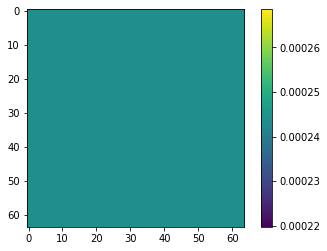

(36, 51)
(16, 36)


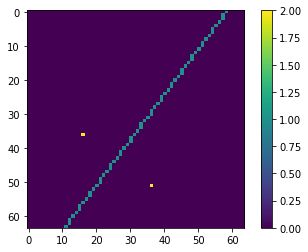

In [4]:
# Create actions:
# Choose 2 points: choose random w prob ~1, linearly decrease to choose max 2 vals in agent's belief
curr_epsilon = np.maximum(((epsilon - 1) / annealing) * curr_timestep + 1, epsilon) # exploration rate (epsilon) at the current timestep

random_sample = np.random.rand()
print("Epsilon: " + str(curr_epsilon))
if curr_epsilon > random_sample:
    # Explore! Choose two random integer pairs
    print("Exploring")
    p1 = (np.random.randint(0,map_shape[0]-1), np.random.randint(0,map_shape[1]-1))
    p2 = (np.random.randint(0,map_shape[0]-1), np.random.randint(0,map_shape[1]-1))
    
else:
    # Choose the two highest points in the array for now -> Later: Output of a neural net
    
    first_peak_val = np.partition(belief.flatten(), -2)[-1]
    first_peak_index = tuple(np.argwhere(belief==first_peak_val)[0])
    second_peak_val = np.partition(belief.flatten(), -2)[-2]
    second_peak_index = tuple(np.argwhere(belief==second_peak_val)[0])
    
    # Validate peaks: (This could be extended to have at least one space in between peaks if necessary)
    count = 0
    if first_peak_index == second_peak_index:
        count += 1
        second_peak_index = tuple(np.argwhere(belief==second_peak_val)[count])
    
    p1 = first_peak_index
    p2 = second_peak_index
    
plot2D(belief)
print(p1)
print(p2)

active[p1[::-1]] = 2
active[p2[::-1]] = 2

# Find endpoints of the cuts based on these points: 2-point Voronoi diagram

midpoint, slope = midPoint_and_slope(p1, p2)
endpoints, raw_endpoints = findEndpoints(midpoint, slope, map_shape)
endp1 = endpoints[0]
endp2 = endpoints[1]

# Draw Bresenham's line: 
# Assume endpoints has two elements
# We need to reverse the order of the points for plotting purposes. See convention above

points = drawLine(endp1[::-1],endp2[::-1])
for i in points:
    active[i] = 1
plot2D(active)

# Cut: Go through each of the spaces in the cutting line if possible, count the effort it takes, update the agent's 
# belief and uncertainty at each point (Need sensor). Return success/not success + amount of work done


# "Analyze cut": Determine if a cut was valid, and if so, if the separated regions are < certain area -> How do we 
# separate the regions? Everything below and to the left is a color until you find a 1, everything above 
# and to the right is another color until you find a 1? Return a quantifiable success metric for the reward


# Update map: Clean up "collected" areas

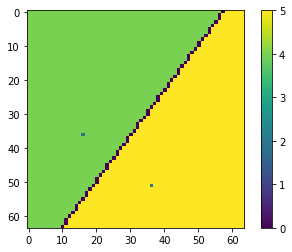

In [5]:
'''
If cut is sucessful we seperate the regions to identify whether it can be collected or not 
'''

for k in range(len(points)):
#     print(points[k])
    i = points[k][0]
    for j in range(points[k][1]-1):
        active[i][j] = 4
    for j in range(64-points[k][1]):
        active[i][-j-1] = 5
active[p1[::-1]] = 2
active[p2[::-1]] = 2
plot2D(active)

In [ ]:
# Calculate reward


In [6]:
# Determine if episode is over or not



In [24]:
#Calculate area and determine if it is small enough to collect or not
threshold = 2000
value = [4,5]
print(value)
for i in value:
    occurrences = np.count_nonzero(active == i)
    print(occurrences)
    if occurrences<=threshold:
        print('Region with value {} is small enough to be picked up' .format(i))

[4, 5]
2143
1887
Region with value 5 is small enough to be picked up
